# Strat review

In [18]:
# Imports
import pandas as pd
from binance.client import Client
from binance.enums import * #https://github.com/sammchardy/python-binance/blob/master/binance/enums.py
import datetime
import json
import math

import schedule
import time
from datetime import datetime, timedelta
from joblib import dump, load

import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import clear_output

def get_api_keys(site: str, api_type: str)->str:
    """
    gets api keys stored in api-keys/api-keys.txt
    site: 'binance'
    api_type: 'api', 'secret'
    """
    with open('../api-keys/api-keys.txt') as json_file:
        return json.load(json_file)[site][api_type]
# Constants
api_key = get_api_keys("binance", "api")
api_secret = get_api_keys("binance", "secret")

client = Client(api_key=api_key, api_secret=api_secret)

In [19]:
def get_filtered_dataframe(df):
    """filters columns and converts columsn to floats and ints respectively"""
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df = df.astype(np.float64)
    df["timestamp"] = df.timestamp.astype(np.int64)
    return df

def get_minutely_data(symbol:str, days=0.5):
    """smart gets minutely data. Enter symbol with USDT"""
    data_past = pd.read_csv(f"../data/{symbol}-past.csv")

    d = datetime.today() - timedelta(days=days)
    start_date = d.strftime("%d %b %Y %H:%M:%S")
    today = datetime.today().strftime("%d %b %Y %H:%M:%S")

    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1MINUTE, start_date, today, 1000)
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data = get_filtered_dataframe(data)

    index = data_past.index[(data_past['timestamp'] == data.iloc[0].timestamp)].tolist()[0]
    data = pd.concat([data_past[:index], data], ignore_index=True, sort=False)

    klines = client.get_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1MINUTE)
    data_latest = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data_latest = get_filtered_dataframe(data_latest)

    index = data.index[(data['timestamp'] == data_latest.iloc[0].timestamp)].tolist()[0]
    result = pd.concat([data[:index], data_latest], ignore_index=True, sort=False)
    result.to_csv(f"../data/{symbol}-past.csv", index=False)
    return result

def get_z_score(): 
    '''gets the latest z-score, given hedge ratio hr.
    Warning, sometimes it gives nan, just rerun (binance's fault)'''
    a = get_minutely_data(ASSET_A + BASE)
    b = get_minutely_data(ASSET_B + BASE)
    a.set_index("timestamp", inplace=True)
    b.set_index("timestamp", inplace=True)
    
    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)
    
    df.dropna(inplace=True)
    
    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(2000).mean()
    spread["std"] =  spread.spread.rolling(2000).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    
    return spread.iloc[-1].zscore

def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

def plots(plot):
    fig, (ax, axz, axc) = plt.subplots(3, figsize=(12,9))

    # close_df.loc['2014':].plot(ax=ax, alpha=.5)
    ax.plot(plot.A, alpha=.7, color="lightblue", label="A")
    ax1 = ax.twinx()
    ax1.plot(plot.B, alpha=.5, color="orange", label="B")


    ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                         alpha=0.75, color='blue', linewidth=0)

    ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                         alpha=0.75, color='blue', linewidth=0)

    ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                         alpha=0.75, color='red', linewidth=0)

    ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                         alpha=0.75, color='red', linewidth=0)
    ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, color='gray', linewidth=0)
    ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, color='gray', linewidth=0)
    ax2 = ax.twinx()
    ax2.plot(plot.cusum, color="gray", alpha=.5)
    ax.legend()
    ax1.legend()

    axz.plot(plot.zscore, color="gray", alpha=.5, label="zscore")
    axz.plot(plot.zscore.reindex(long_a), marker='o', markersize=7,
                         alpha=0.75, label='long_a', color='lightblue', linewidth=0)
    axz.plot(plot.zscore.reindex(long_b), marker='o', markersize=7,
                         alpha=0.75, label='long_b', color='orange', linewidth=0)
    axz.plot(plot.zscore.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, label='liquidate', color='gray', linewidth=0)

    axz.legend()

    axc.scatter(plot.index, plot.diffs[plot.diffs > 0].reindex(plot.index)*100/plot.cusum, color="green", alpha=.5)
    axc.scatter(plot.index, plot.diffs[plot.diffs <= 0].reindex(plot.index)*100/plot.cusum, color="red", alpha=.5)
    axc.axhline(0, linestyle="--", color="blue", alpha=.5)
    axc1 = axc.twinx()
    axc1.plot(plot.cusum, color="gray", alpha=.5)

In [20]:
ASSET_A = "CELR"
ASSET_B = "FET"
BASE = "USDT"
get_z_score()

2.121439167736822

In [21]:
df1 = pd.read_csv("../data/CELRUSDT-past.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/FETUSDT-past.csv", index_col=0, parse_dates=True)
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
hedgeRatio = results.params[1]
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(2000).mean()
spread["std"] =  spread.spread.rolling(2000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
spread = spread.dropna()
spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)
spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)
spread.index = (range(len(spread)))

In [22]:
# Buy  random value between high and low, now correct LONG A or B
total = 100.
fee = 0.002       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel
cusum = []
price_a = None
price_b = None
long = None       #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
trades = 0
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            trades += 1
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            if z>thres: 
                price_a = [ah, ((total/2)/ah)*(1.-fee)]
                price_b = [bl, ((total/2)/bl)*(1.-fee)]
                long = "A"
                long_a.append(spread.index[i])
            elif z<-thres:
                price_a = [al, ((total/2)/al)*(1.-fee)]
                price_b = [bh, ((total/2)/bh)*(1.-fee)]
                long = "B"
                long_b.append(spread.index[i])
    if long == "B" and z>sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
        total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "A" and z<-sell_thres: #Liquidate positions
        al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
        total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
        total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

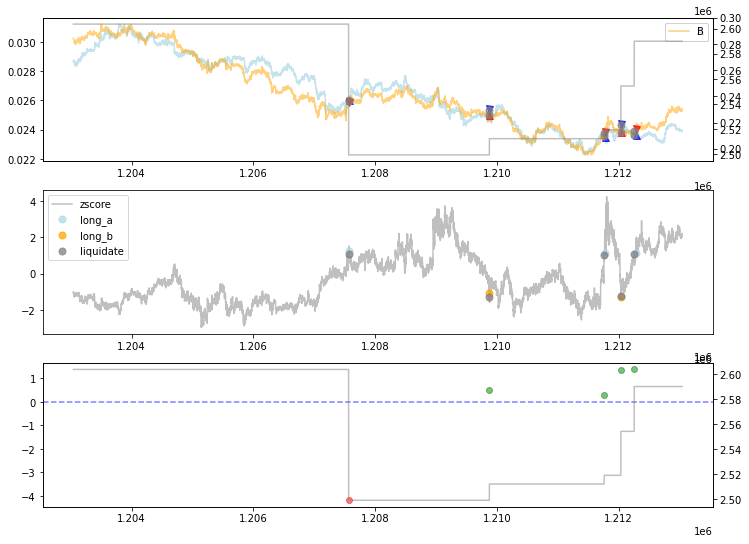

In [23]:
plot = spread
plot["cusum"] = cusum

s = list(pd.Series(cusum).diff())
s = pd.Series(s, index=spread.index)
plot["diffs"] = s[s != 0.]


plot = plot[-10000:] #500_000:700_000

plots(plot)